In [5]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shpg
from scipy.interpolate import griddata
import matplotlib.pylab as pylab
from eod import msg as msg
import cartopy.crs as ccrs
import cartopy.feature as cfeature
pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline
import pyproj
import cleo
import salem
import pickle as pkl

In [6]:
HOD=range(24)   # hours of day
CFAC=-781648343
LFAC=-781648343
COFF=1856
LOFF=1856
YRANGE=range(2004,2014)

tpath= "/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA/"
tf=msg.extract_TRMMfile(tpath, hod=HOD, yrange=YRANGE, mtresh=1)
tf.keys()
print(len(tf['fpath']))

1064


In [7]:
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=0)

In [8]:
tnb=np.array(range(len(tf['fpath'])))
maxs=[]
for tp in tnb:
    dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=tp)
    td=dtrmm['pcp'].mean().max()
    maxs.append(td)
sort_max, sort_nbs = zip(*sorted(zip(maxs, tnb), reverse=True))

In [9]:
print(sort_max[0:10])
print(sort_nbs[0:10])

(1.4574619424316959, 1.2604372566636717, 0.94629474740715935, 0.78822898650985818, 0.75571597933779322, 0.72896770358628882, 0.71934199688844147, 0.70978014394163458, 0.7065073397780165, 0.70113297988234424)
(334, 490, 845, 437, 730, 696, 841, 79, 992, 288)


In [14]:
top5=sort_nbs[0:5]
print(top5)

(334, 490, 845, 437, 730)


In [15]:
NB=top5[2]
mi=tf['tmins'][NB]
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=NB)
mlat=dmsg['lats']
mlon=dmsg['lons']
md=dmsg['t']
tlat=dtrmm['lats']
tlon=dtrmm['lons']
td=dtrmm['pcp']
print(mi)
mlon.flatten()

27


array([-16.78334045, -16.75442505, -16.72542572, ...,  32.65229416,
        32.69068527,  32.72912598], dtype=float32)

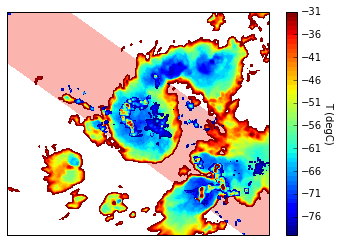

In [25]:
dy1=0
dy2=300
dx1=30
dx2=400
tdy1=80
tdy2=400

ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(tlon[tdy1:tdy2, :], tlat[tdy1:tdy2, :], td[tdy1:tdy2, :],levels=np.arange(0,100, 0.5), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(mlon[dy1:dy2, dx1:dx2], mlat[dy1:dy2, dx1:dx2], md[dy1:dy2, dx1:dx2], levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree())
cbar=plt.colorbar()
cbar.set_label('T (degC)', rotation=270, labelpad=+11)
plt.contourf(tlon[tdy1:tdy2, :], tlat[tdy1:tdy2, :], td[tdy1:tdy2, :],levels=np.arange(5,70, 0.5), transform=ccrs.PlateCarree())

#ax.coastlines()
#cbar=plt.colorbar()
#cbar.set_label('PCP (mm h-1)', rotation=270, labelpad=+11)
#plt.savefig('/users/global/cornkle/'+str(NB)+'_msgtd0_p_'+str(mi)+'.pdf')

In [34]:
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
grid = salem.Grid(nxny=(300, 300), dxdy=(5000, 5000), ll_corner=(-1600000., -45000.), proj=proj)

In [35]:
# Transform lons, lats to grid
xm, ym = grid.transform(mlon[dy1:dy2, dx1:dx2].flatten(), mlat[dy1:dy2, dx1:dx2].flatten(), crs=salem.wgs84)
xt, yt = grid.transform(tlon.flatten(), tlat.flatten(), crs=salem.wgs84)

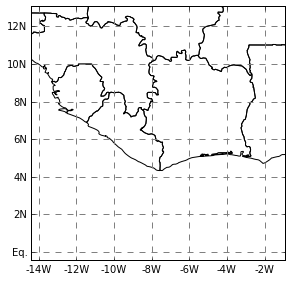

In [36]:
cm = cleo.Map(grid)
cm.visualize()

In [37]:
# Grid x, y
xi, yi = grid.ij_coordinates

In [38]:
# Convert for griddata input 
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T

In [39]:
# Interpolate using delaunay triangularization 
outm = griddata(mpoints, md[dy1:dy2, dx1:dx2].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))

In [40]:
# Interpolate using delaunay triangularization 
outt = griddata(tpoints, td.flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx))

In [45]:
outt

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

/users/global/cornkle/data/pythonWorkspace/proj_CEH/cleo/graphics.py:174: RuntimeWarning: Minimum data out of bounds.
  warnings.warn('Minimum data out of bounds.', RuntimeWarning)
/users/global/cornkle/data/pythonWorkspace/proj_CEH/cleo/graphics.py:176: RuntimeWarning: Maximum data out of bounds.
  warnings.warn('Maximum data out of bounds.', RuntimeWarning)


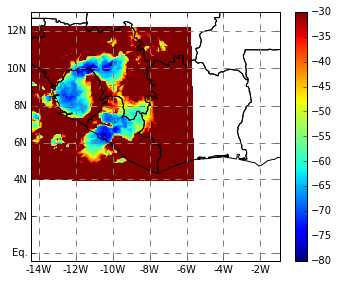

In [42]:
# show the data
cm.set_cmap(plt.cm.jet)
cm.set_plot_params(vmin=-80, vmax=-30, extend='neither')
cm.set_nlevels(256)
cm.set_data(outm,  overplot=True)
#cm.set_data(outt, overplot=True, )
cm.visualize()

ValueError: Dimensions of data do not match the map.

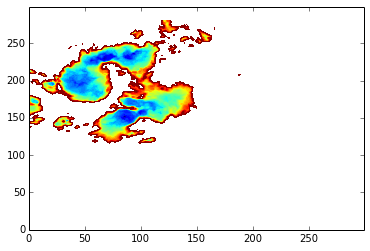

In [139]:
plt.contourf(yi.T, xi.T, outm,levels=np.arange(-80,-30,1))
#plt.contourf(yi.T, xi.T, outt, levels=np.arange(5,70, 0.5))
plt.savefig('/users/global/cornkle/'+str(NB)+'_msgtest_'+str(mi)+'.pdf')

In [5]:
dic = pkl.load( open ('/users/global/cornkle/mt_wavelet_test.p', 'rb'))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xcc in position 0: ordinal not in range(128)